# <center> Project <center>

# <center> Inflation Prediction <center>

# <center> Prabesh Sapkota <center>

# Merging data and Loading


In [2]:
import pandas as pd

month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# pre-processing exchange rate

exchange_rate: pd.DataFrame = pd.read_excel('dataa/Exchange-rate.xlsx')

exchange_rate['Year'] = exchange_rate['Year'].fillna(method='ffill')

exchange_rate['Year'] = exchange_rate['Year'].astype(str).apply(lambda x: x.split('/')[0])

exchange_rate['Month'] = exchange_rate['Month'].map(month_mapping)

exchange_rate = exchange_rate.dropna(subset=['Month'])

exchange_rate['Date'] = exchange_rate['Year'] + '-' + exchange_rate['Month'].astype(int).astype(str) + '-01'

exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'], format='%Y-%m-%d')

exchange_rate = exchange_rate[['Date', 'Rate']]
exchange_rate.rename(columns={'Rate': 'Exchange Rate'}, inplace=True)


# pre-processing gpd data
gdp_data = pd.read_excel('dataa/GDP.xlsx')


new_gdp_data = []
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for _, row in gdp_data.iterrows():
    year = int(row['Year'])
    for month in months:
        date = f"{year}-{int(month)}-01"
        new_row = [date] + row[1:].tolist()
        new_gdp_data.append(new_row)


new_gdp_data = pd.DataFrame(new_gdp_data, columns=['Date', 'GDP', 'Per Capita', 'Growth', 'Trade Balance (USD Billion)', '% of GDP', 'Contribution of Manufactoring Industry to GDP', 'No of People Going for Foreign Employment'])
new_gdp_data['Date'] = pd.to_datetime(new_gdp_data['Date'])

# Interpolate missing values linearly
new_gdp_data['GDP'] = new_gdp_data['GDP'].interpolate(method='linear')

# merge new_gdp_data and exchange_rate
exchange_rate_gdp_data = pd.merge(exchange_rate, new_gdp_data, on='Date', how='left')


# pre-processing government data
government_revenue = pd.read_excel('dataa/Government-Revenue-and-Expenditure.xlsx')
government_revenue.fillna(government_revenue.mean(), inplace=True)
government_revenue['Date'] = pd.to_datetime(government_revenue['Date'])
# Extract year and month from 'Date' for grouping
government_revenue['YearMonth'] = government_revenue['Date'].dt.to_period('M')

# Group by Year-Month and sum 'Total Receipts of GON' and 'Total Expenditure'
monthly_data = government_revenue.groupby('YearMonth').agg(
    Monthly_Income=pd.NamedAgg(column='Total Receipts of GON', aggfunc='sum'),
    Monthly_Expenditure=pd.NamedAgg(column='Total Expenditure', aggfunc='sum')
).reset_index()

# Convert YearMonth to first date of the month
monthly_data['Date'] = monthly_data['YearMonth'].dt.start_time

government_revenue = monthly_data[['Date', 'Monthly_Income', 'Monthly_Expenditure']]

# merge exchange_rate_gdp_data and government_revenue
exchange_rate_gdp_govermment_data = pd.merge(government_revenue, exchange_rate_gdp_data, on='Date', how='left')
exchange_rate_gdp_govermment_data.head()


# inflation preprocessing
inflation = pd.read_excel('dataa/Inflation.xlsx')
inflation['Month'] = inflation['Month'].map(month_mapping)
inflation.dropna(inplace=True)
inflation['Date'] = inflation['Year'].astype(int).astype(str) + '-' + inflation['Month'].astype(int).astype(str) + '-01'
inflation['Date'] = pd.to_datetime(inflation['Date'], format='%Y-%m-%d')
inflation = inflation[['Date','Index','Change']]

# merge infaltion to above data
nepal_economy = exchange_rate_gdp_govermment_data.merge(inflation, on='Date', how='left')


# liquidity preprocessing

liquidity = pd.read_excel('dataa/Liquidity.xlsx')
liquidity['Date'] = pd.to_datetime(liquidity['Date'])

# Replace '-' with NaN and convert the columns to numeric
liquidity['Balance at NRB minus CRR'] = pd.to_numeric(
    liquidity['Balance at NRB minus CRR'].replace('-', pd.NA), errors='coerce')
liquidity['Prime Rate'] = pd.to_numeric(
    liquidity['Prime Rate'].replace('-', pd.NA), errors='coerce')
liquidity['Secondary Rate'] = pd.to_numeric(
    liquidity['Secondary Rate'].replace('-', pd.NA), errors='coerce')

# Extract Year-Month to group by month
liquidity.fillna(liquidity.mean(), inplace=True)
liquidity['YearMonth'] = liquidity['Date'].dt.to_period('M')

# Group by YearMonth and calculate monthly averages
liq_monthly_avg = liquidity.groupby('YearMonth').agg({
    'Balance at NRB minus CRR': 'mean',
    'Prime Rate': 'mean',
    'Secondary Rate': 'mean'
}).reset_index()

# Set Date as the first day of each month
liq_monthly_avg['Date'] = liq_monthly_avg['YearMonth'].dt.start_time

liq_monthly_avg = liq_monthly_avg[['Date', 'Balance at NRB minus CRR', 'Prime Rate', 'Secondary Rate']]
liq_monthly_avg.head()


#merge liquidity to nepal economy
nepal_economy = nepal_economy.merge(liq_monthly_avg, on='Date', how='left')


# preprocessing interest rate
interest_rate: pd.DataFrame = pd.read_excel('dataa/Nepal bank Base Interest Rate.xlsx')
#Melt the dataframe to convert months as rows
interest_rate = interest_rate.melt(id_vars=["FY"], var_name="Month", value_name="Interest Rate")

interest_rate['Date'] = pd.to_datetime(interest_rate['FY'].astype(str) + '-' + interest_rate['Month'] + '-01')

interest_rate = interest_rate[['Date', 'Interest Rate']]

# merge interest_rate to nepal economy
nepal_economy = nepal_economy.merge(interest_rate, on='Date', how='left')
nepal_economy.fillna(nepal_economy.mean(),inplace=True)

# use date as index

nepal_economy.set_index('Date', inplace=True)

nepal_economy.to_excel('dataa/merged_data.xlsx',index=False)

nepal_economy.head()

C:\Users\prabe\AppData\Local\Temp\ipykernel_13988\2926661972.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exchange_rate['Year'] = exchange_rate['Year'].fillna(method='ffill')


,Monthly_Income,Monthly_Expenditure,Exchange Rate,GDP,Per Capita,Growth,Trade Balance (USD Billion),% of GDP,Contribution of Manufactoring Industry to GDP,No of People Going for Foreign Employment,Index,Change,Balance at NRB minus CRR,Prime Rate,Secondary Rate,Interest Rate
Date,,,,,,,,,,,,,,,,
2021-07-01,283360.9,12701.9,125.087273,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,142.42,4.35,73177.185691,2.027138,2.795923,7.01
2021-08-01,3004465.2,400482.7,118.800000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,142.40,3.49,27265.603242,3.477316,3.525055,6.83
2021-09-01,5382410.0,2358148.0,117.590000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,143.42,4.24,22785.998293,4.684064,4.541698,6.81
2021-10-01,8406644.5,5903400.0,120.420000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,146.54,6.04,29193.264593,4.456972,4.649000,6.70
2021-11-01,10677412.8,8726185.2,119.180000,36.28883,1222.8788,4.2469,-12.117845,-33.3928,4.665598,50000.0,146.09,7.11,18026.791357,4.533005,4.685647,6.38


In [3]:

print(nepal_economy.index)

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


#  Data Loading and Preprocessing of Merged file

In [4]:
import pandas as pd
import numpy as np


# # Load the data from the Excel file
# df = pd.read_excel('assignment_data/merged_data.xlsx')

# # Replace any `NaN` values explicitly with `np.nan` (just in case they are not recognized as `NaN`)
# nepal_economy = nepal_economy.replace({None: np.nan})

# # Fill NaN values using forward fill method
# nepal_economy = nepal_economy.apply(lambda col: col.fillna(method='ffill'))

# # Print the modified DataFrame
print(nepal_economy.columns)



Index(['Monthly_Income', 'Monthly_Expenditure', 'Exchange Rate', 'GDP',
       'Per Capita', 'Growth', 'Trade Balance (USD Billion)', '% of GDP',
       'Contribution of Manufactoring Industry to GDP',
       'No of People Going for Foreign Employment', 'Index', 'Change',
       'Balance at NRB minus CRR', 'Prime Rate', 'Secondary Rate',
       'Interest Rate'],
      dtype='object')


# Scaling of Features

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming 'nepal_economy' is your DataFrame
# Initialize the scaler
scaler = StandardScaler()

# Scale all numerical columns (ignoring the index)
scaled_values = scaler.fit_transform(nepal_economy)

# Create a new DataFrame with scaled values, keeping the index
df_scaled = pd.DataFrame(scaled_values, columns=nepal_economy.columns, index=nepal_economy.index)

# Print to verify
print(df_scaled.head())


            Monthly_Income  Monthly_Expenditure  Exchange Rate           GDP  \
Date                                                                           
2021-07-01       -1.529124            -1.457213   3.660416e-15 -7.105427e-15   
2021-08-01       -1.202575            -1.413072  -1.619469e+00 -7.105427e-15   
2021-09-01       -0.917206            -1.190231  -1.931139e+00 -7.105427e-15   
2021-10-01       -0.554279            -0.786676  -1.202191e+00 -7.105427e-15   
2021-11-01       -0.281773            -0.465358  -1.521589e+00 -7.105427e-15   

              Per Capita        Growth  Trade Balance (USD Billion)  \
Date                                                                  
2021-07-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-08-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-09-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-10-01  2.273737e-13  8.881784e-16                -1.776357e-15   
2021-11-01  2

# Correlation Analysis utilizing heatmap and RFE
- for best features selection

In [6]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt



# Compute the correlation matrix
corr_matrix = df_scaled.corr()
# Find the most important feature based on correlation with the target variable (Inflation Index)
target_variable = 'Index'  #  Inflation Index
correlation_with_target = corr_matrix[target_variable].abs().sort_values(ascending=False)
print("Correlation with target variable (Inflation Index):")
print(correlation_with_target)

# Define the feature matrix (X) and target vector (y)
X = df_scaled.drop(columns=[target_variable])
y = df_scaled[target_variable]

# Use RFE with Linear Regression to select important features
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)  # You can change the number of features to select
fit = rfe.fit(X, y)

# Print the ranking of features
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': fit.ranking_})
print("\nFeature ranking based on RFE:")
print(feature_ranking.sort_values(by='Ranking'))

# Select the most important features
selected_features = feature_ranking[feature_ranking['Ranking'] == 1]['Feature']
print("\nSelected features:")
print(selected_features)

Correlation with target variable (Inflation Index):
Index                                            1.000000
Secondary Rate                                   0.830907
Change                                           0.775715
Prime Rate                                       0.769968
Exchange Rate                                    0.675405
Balance at NRB minus CRR                         0.478510
Monthly_Expenditure                              0.239482
Interest Rate                                    0.179694
Monthly_Income                                   0.068403
GDP                                                   NaN
Per Capita                                            NaN
Growth                                                NaN
Trade Balance (USD Billion)                           NaN
% of GDP                                              NaN
Contribution of Manufactoring Industry to GDP         NaN
No of People Going for Foreign Employment             NaN
Name: Index, dtype: 

# Split into Train and Test

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Use only the selected features for model training
X_selected = X[selected_features]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)






# Regression Models
- Linear Regression Model for Inflation

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Building and evaluating Linear Regression Model
# Initialize and train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate models
def evaluate_model(y_test, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("-------------------------------------")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print("-------------------------------------")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
    print("-------------------------------------")
    print(f"R^2: {r2_score(y_test, y_pred)}\n")

evaluate_model(y_test,y_pred_lr,"LinearRegression")

--- LinearRegression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.9266617076042197
-------------------------------------
Mean Absolute Error (MAE): 0.697585681543828
-------------------------------------
R^2: 0.49357678792801685



- Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
# Building and evaluating Random Forest Regressor
# Initialize and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model (using Mean Squared Error)
evaluate_model(y_test,y_pred_rf,"Random Forest Regression")


--- Random Forest Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.5783530882034911
-------------------------------------
Mean Absolute Error (MAE): 0.5209520470118925
-------------------------------------
R^2: 0.8027317067195164



- Gradient Boosting 

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# Building and Evluating Gradient Boosting Regressor
grb_model = GradientBoostingRegressor(random_state=42)
grb_model.fit(X_train, y_train)

# Make Predictions on test
y_pred_grb = grb_model.predict(X_test)

# Evaluating the model
evaluate_model(y_test,y_pred_grb,"Gradient Boosting Regression")

--- Gradient Boosting Regression ---
-------------------------------------
Root Mean Squared Error (RMSE): 0.5531072141530694
-------------------------------------
Mean Absolute Error (MAE): 0.49010088971851556
-------------------------------------
R^2: 0.8195778659674781



# Hypertuning
- Linear Regression not included due to lack of hyper parameters for tuning.

In [11]:
from sklearn.model_selection import GridSearchCV #Automates the process of hyperparameter tuning
# Models and hyperparameters
models_and_params = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            # 'min_samples_leaf': [1, 2, 4]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 10],
            # 'min_samples_split': [2, 5, 10], 
            # 'min_samples_leaf': [1, 2, 4]
        }
    }
}

# Tune models
best_models = {}
for name, item in models_and_params.items():
    grid_search = GridSearchCV(item['model'], item['params'], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [14]:
# Selecting the best model
best_model = max(best_models.items(), key=lambda x: r2_score(y_test, x[1].predict(X_test)))
print(f"The best model is {best_model[0]} with R^2: {r2_score(y_test, best_model[1].predict(X_test))}")

The best model is Gradient Boosting with R^2: 0.8195744937529927


# Prediction

c:\Users\prabe\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


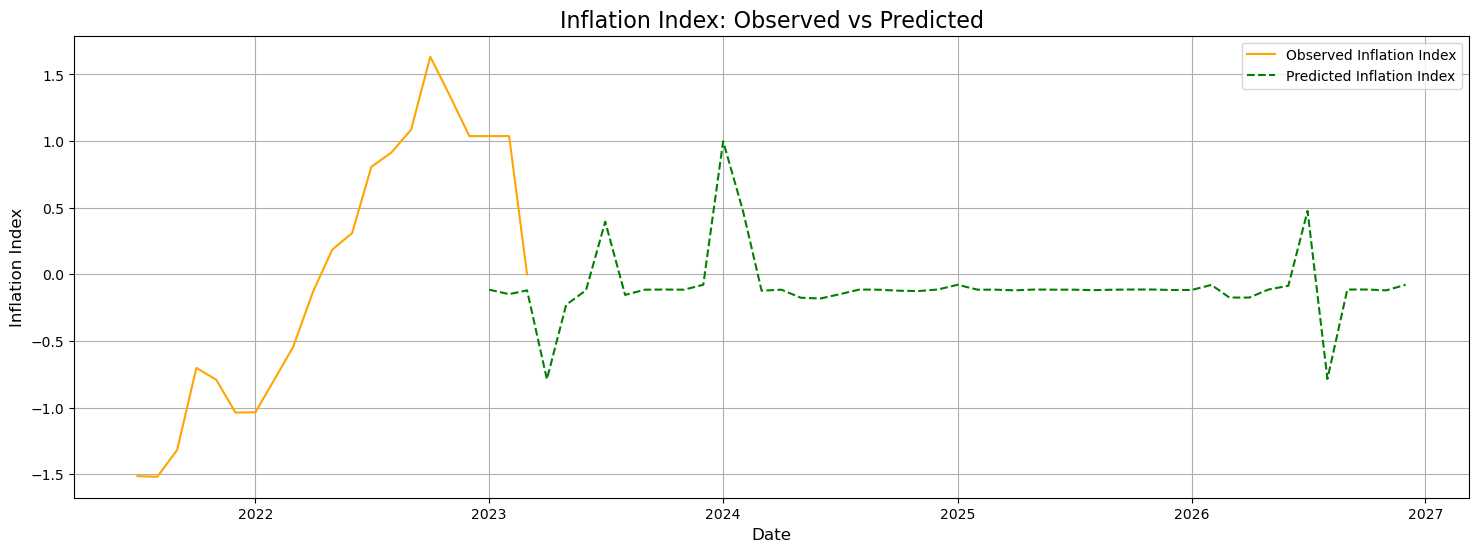

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

# 1. Extract observed inflation index (unscaled) from df_scaled
observed_inflation_index = df_scaled['Index']

# 2. Generate future dates
future_dates = pd.date_range(start='2023-01-01', end='2026-12-31', freq='MS')

# 3. Prepare the future features for the years 
selected_features_train = ['Monthly_Income', 'Monthly_Expenditure', 'Exchange Rate', 'GDP', 'Per Capita', 
                           'Growth', 'Trade Balance (USD Billion)', '% of GDP', 'Contribution of Manufactoring Industry to GDP', 
                           'Interest Rate']

# Calculate the mean values of the selected features from the training data (df_scaled)
mean_values = df_scaled[selected_features_train].mean()

# Introducing small random fluctuations (standard deviation of 0.1) for variability
np.random.seed(42)  # Set seed for reproducibility
variability = np.random.normal(loc=0, scale=0.1, size=(len(future_dates), len(selected_features_train)))

# Create future feature DataFrame with added variability
future_features = pd.DataFrame(mean_values.values + variability, index=future_dates, columns=selected_features_train)

# 4. Scale the future features using the same scaler that was used during training
scaler = StandardScaler()
scaler.fit(df_scaled[selected_features_train])  # Fit the scaler on the training data
future_features_scaled = scaler.transform(future_features)  # Scale the future features

# 5. Ensure `grb_model` is your trained Gradient Boosting model and use it for inference
# Predict future inflation index using the trained model (for inference in 2020-2030)
future_predictions = grb_model.predict(future_features_scaled)

# 6. Feature Importance Inference
# Extract feature importance from the trained model to understand which features have the greatest impact
feature_importance = grb_model.feature_importances_


# Plot the observed inflation index for the available data
plt.figure(figsize=(18, 6))

# Plot observed inflation index
plt.plot(df_scaled.index, observed_inflation_index, label='Observed Inflation Index', color='orange')

# Plot predicted inflation index for 2020-2030
plt.plot(future_dates, future_predictions, label='Predicted Inflation Index', color='green', linestyle='--')

# Add title and labels
plt.title('Inflation Index: Observed vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Index', fontsize=12)
plt.legend()
plt.grid()

# Show the plot
plt.show()